In [3]:
!pip install torchinfo

In [4]:
# import libraries
import os
import operator
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
###
from torch import Tensor
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
###
from typing import Optional, Union
from tqdm import tqdm
from functools import reduce
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
###
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
Numpy version: 2.0.2


In [5]:
# Define a method to Scale the intensity of the input data between minv and maxv
class ScaleIntensity:
    def __init__(self, minv=0.0, maxv=1.0):
        self.minv = minv
        self.maxv = maxv

    def __call__(self, img):
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min)
        img = img * (self.maxv - self.minv) + self.minv
        return img

In [6]:
# how many samples per batch to load
batch_size = 64
train_valid_ratio = 0.8

# define intensity range for each input data to perform image normalization
minv = 0
maxv = 1

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=2),
    ScaleIntensity(minv=minv, maxv=maxv)
])

# Path to store MNIST dataset
data_dir = "data/MNIST"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# choose the training and test datasets
train_dataset = datasets.MNIST(root='data', train=True, download=download, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=download, transform=transform)

# Split the train_data into a train (80%) and valid (20%) subdataset
train_size = int(train_valid_ratio * len(train_dataset))      # 80% for training
valid_size = len(train_dataset) - train_size    # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 130MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 37.4MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 24.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.77MB/s]


Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 10000


The image batch size is (64, 1, 32, 32)


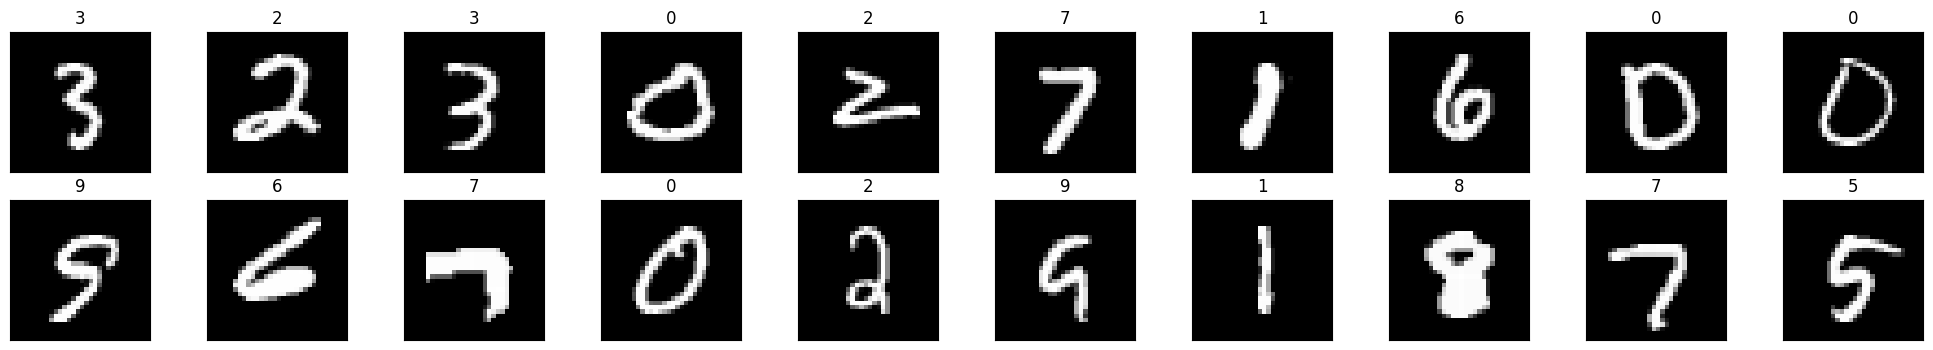

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
print(f"The image batch size is {images.shape}")

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

The size of an image from the dataset is (32, 32)


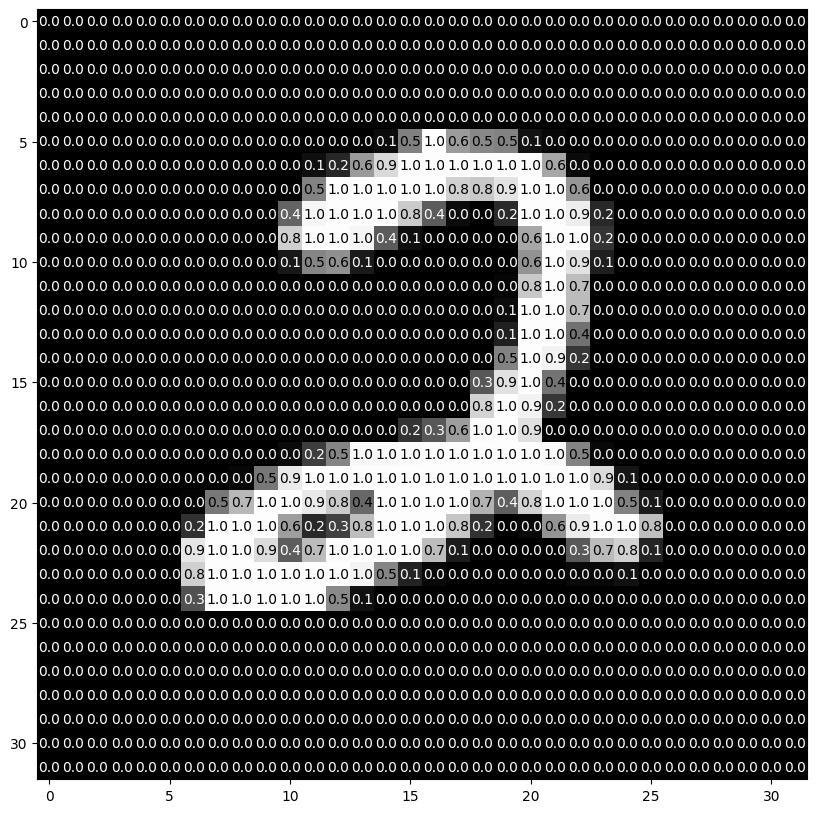

In [9]:
img = np.squeeze(images[1])
print(f"The size of an image from the dataset is {img.shape}")

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

The size of an image from the dataset is (32, 32)
Min value: -1.00, Max value: 5.00


Text(0.5, 1.0, 'Pixel Values Rescaled to [-1, 5]')

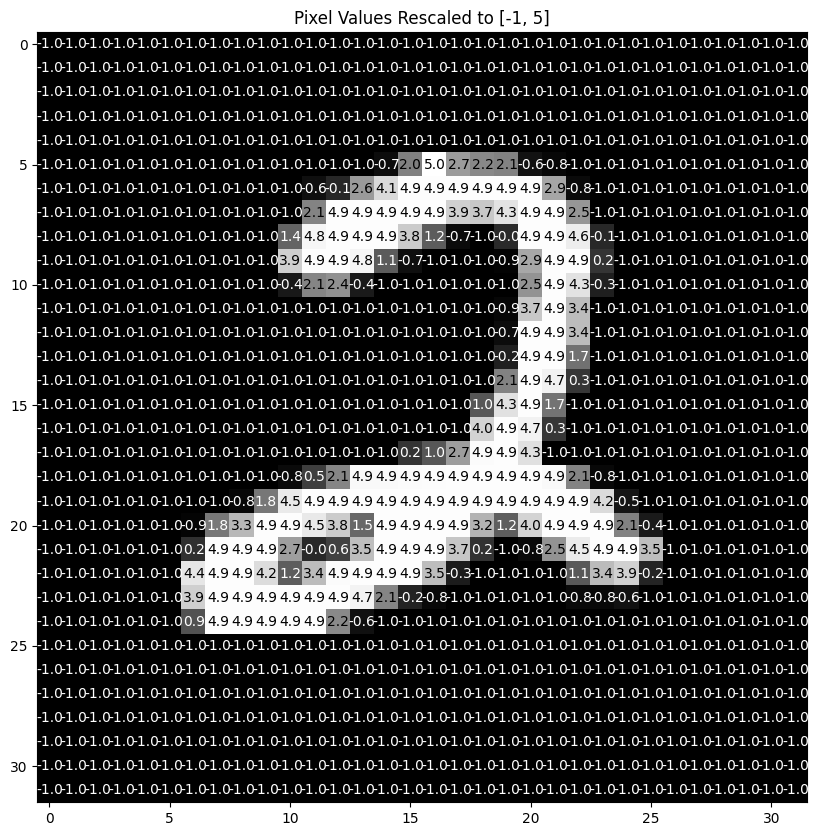

In [10]:
# CODE MODIFIÉ POUR REMISE À L'ÉCHELLE ENTRE -1 ET 5

# img = np.squeeze(images[1]) # L'image est un tenseur (ou numpy array)
# La forme de img est (32, 32), avec des valeurs dans [0, 1]

# Modification : Remise à l'échelle des valeurs entre -1 et 5
img_scaled = img * 6 - 1

print(f"The size of an image from the dataset is {img_scaled.shape}")
print(f"Min value: {img_scaled.min():.2f}, Max value: {img_scaled.max():.2f}")

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

# Affiche l'image mise à l'échelle. Utilisez vmin/vmax pour fixer l'échelle de couleur.
ax.imshow(img_scaled, cmap='gray', vmin=-1, vmax=5)
width, height = img_scaled.shape
thresh = img_scaled.max()/2.5 # Note : Le seuil basé sur le max peut ne pas être optimal ici
thresh = 2 # Un seuil fixe peut être plus approprié

for x in range(width):
    for y in range(height):
        # Utiliser img_scaled pour les valeurs
        val = round(img_scaled[x][y],2)
        # Rendre l'annotation plus lisible si l'image est inversée ou sombres
        color_choice = 'white' if val < thresh else 'black'

        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color=color_choice)
# Le titre reflète la nouvelle plage.
ax.set_title("Pixel Values Rescaled to [-1, 5]")

The size of an image from the dataset is (32, 32)
Min value: 0.00, Max value: 1.00


Text(0.5, 1.0, 'Pixel Values Rescaled to [0, 1]')

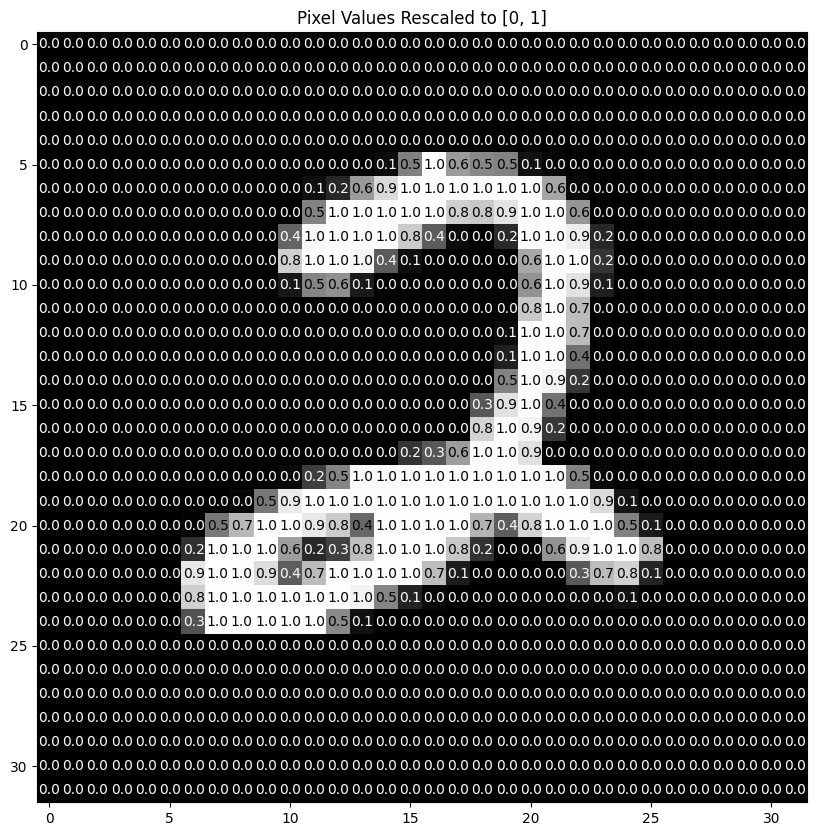

In [11]:
# CODE REMODIFIÉ POUR REMISE À L'ÉCHELLE ENTRE 0 ET 1

# img = np.squeeze(images[1]) # L'image est un tenseur (ou numpy array)
# La forme de img est (32, 32), avec des valeurs dans [0, 1]

# Modification : Remise à l'échelle (Identité) des valeurs entre 0 et 1
# Si l'entrée est déjà dans [0, 1], cette ligne ne fait rien, mais assure la plage.
img_scaled = img * 1 + 0 # équivalent à img_scaled = img

print(f"The size of an image from the dataset is {img_scaled.shape}")
print(f"Min value: {img_scaled.min():.2f}, Max value: {img_scaled.max():.2f}")

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

# Affiche l'image mise à l'échelle.
ax.imshow(img_scaled, cmap='gray', vmin=0, vmax=1)
width, height = img_scaled.shape
thresh = img_scaled.max()/2.5

for x in range(width):
    for y in range(height):
        # Utiliser img_scaled pour les valeurs
        val = round(img_scaled[x][y],2) if img_scaled[x][y] !=0 else 0

        # Le code d'origine de l'annotation est réutilisé ici
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img_scaled[x][y]<thresh else 'black')
# Le titre reflète la nouvelle plage.
ax.set_title("Pixel Values Rescaled to [0, 1]")

In [12]:
# Parameters
spatial_dims = 2
in_shape = (32, 32)
out_channels = 1
latent_size = 2
channels = (16, 32, 64)
strides = (1, 2, 2)

In [13]:
# define the encoder
class Encoder(nn.Module):
    def __init__(self, in_shape, channels, strides, latent_size):
        super(Encoder, self).__init__()
        # define the convolutional layers for downsampling and feature
        # extraction
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=strides[0], padding=1)
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=strides[1], padding=1)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=strides[2], padding=1)
        # define a flatten layer to flatten the tensor before feeding it into
        # the fully connected layer
        self.flatten = nn.Flatten()
        # define fully connected layers to transform the tensor into the desired
        # embedding dimensions
        last_feature_size = np.zeros(2)
        last_feature_size[0] = in_shape[0] // (reduce(operator.mul, strides))
        last_feature_size[1] = in_shape[1] // (reduce(operator.mul, strides))
        last_feature_size = np.array(last_feature_size, dtype=int)
        intermediate_size = channels[2] * last_feature_size[0] * last_feature_size[1]
        self.fc = nn.Linear(intermediate_size, latent_size)

    def forward(self, x):
        # apply convolutional layers with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the tensor
        x = self.flatten(x)
        # get the corresponding latent vector
        z = self.fc(x)
        return z


# define the decoder
class Decoder(nn.Module):
    def __init__(self, in_shape, channels, strides, latent_size):
        super(Decoder, self).__init__()
        # define a fully connected layer to transform the latent vector back to
        # the shape before flattening
        last_encoder_feature_size = np.zeros(2)
        last_encoder_feature_size[0] = in_shape[0] // (reduce(operator.mul, strides))
        last_encoder_feature_size[1] = in_shape[1] // (reduce(operator.mul, strides))
        last_encoder_feature_size = np.array(last_encoder_feature_size, dtype=int)
        intermediate_size = channels[2] * last_encoder_feature_size[0] * last_encoder_feature_size[1]
        self.fc = nn.Linear(latent_size,intermediate_size)
        # define a reshape function to reshape the tensor back to its original
        # shape
        shape_before_flattening = (channels[2], last_encoder_feature_size[0], last_encoder_feature_size[1])
        self.reshape = lambda x: x.view(-1, *shape_before_flattening)
        # define the transposed convolutional layers for the decoder to upsample
        # and generate the reconstructed image
        self.deconv1 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=strides[2], padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=strides[1], padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(channels[0], 1, 3, stride=strides[0], padding=1, output_padding=0)

    def forward(self, x):
        # pass the latent vector through the fully connected layer
        x = self.fc(x)
        # reshape the tensor
        x = self.reshape(x)
        # apply transposed convolutional layers with relu activation function
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        # apply the final transposed convolutional layer with a sigmoid
        # activation to generate the final output
        x = torch.sigmoid(self.deconv3(x))
        return x


# define the vae class
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        # initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        # pass the input through the encoder to get the latent vector
        z = self.encoder(x)
        # pass the latent vector through the decoder to get the reconstructed
        # image
        reconstruction = self.decoder(z)
        # return the mean, log variance and the reconstructed image
        return reconstruction, z

# Instantiate the encoder and decoder models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(in_shape, channels, strides, latent_size).to(device)
decoder = Decoder(in_shape, channels, strides, latent_size).to(device)
# pass the encoder and decoder to VAE class
model = AE(encoder, decoder).to(device)


In [14]:
# Print the summary of the encoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0
)
summary(encoder, (1, 1, 32, 32), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Encoder                                  [1, 1, 32, 32]            [1, 2]                    --                        --
├─Conv2d: 1-1                            [1, 1, 32, 32]            [1, 16, 32, 32]           [3, 3]                    160
├─Conv2d: 1-2                            [1, 16, 32, 32]           [1, 32, 16, 16]           [3, 3]                    4,640
├─Conv2d: 1-3                            [1, 32, 16, 16]           [1, 64, 8, 8]             [3, 3]                    18,496
├─Flatten: 1-4                           [1, 64, 8, 8]             [1, 4096]                 --                        --
├─Linear: 1-5                            [1, 4096]                 [1, 2]                    --                        8,194
Total params: 31,490
Trainable params: 31,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.54
Input size (MB): 0.0

In [15]:
# Print the summary of the decoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0
)
summary(decoder, (1, 1, 2), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Decoder                                  [1, 1, 2]                 [1, 1, 32, 32]            --                        --
├─Linear: 1-1                            [1, 1, 2]                 [1, 1, 4096]              --                        12,288
├─ConvTranspose2d: 1-2                   [1, 64, 8, 8]             [1, 32, 16, 16]           [3, 3]                    18,464
├─ConvTranspose2d: 1-3                   [1, 32, 16, 16]           [1, 16, 32, 32]           [3, 3]                    4,624
├─ConvTranspose2d: 1-4                   [1, 16, 32, 32]           [1, 1, 32, 32]            [3, 3]                    145
Total params: 35,521
Trainable params: 35,521
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 9.62
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.14
Estimated Total Size (MB): 0.38

In [16]:
## Specify loss and optimization functions
learning_rate = 0.001

def loss_function(x_reconstructed, x):
    loss = nn.BCELoss() # Binary cross entropy function
    # loss = nn.L1Loss()
    return loss(x_reconstructed, x)

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [17]:
# Number of epochs to train the model
n_epochs = 5

# Move the model to the device
model = model.to(device)

# Lists to store loss and accuracy for each epoch
train_loss_list = []
valid_metric_list = []

best_valid_metric = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    model.train()  # ensure the model is in training mode
    recon_metric = 0

    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        inputs = batch_data[0].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        recon_batch, _ = model(inputs)
        # calculate the loss
        loss = loss_function(recon_batch, inputs)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        recon_metric += loss.item() * inputs.size(0)

    # Calculate average training loss and accuracy over the epoch
    train_loss_list.append(recon_metric / len(train_loader.dataset))

    ###################
    # Validation step #
    ###################
    model.eval()  # set model to evaluation mode
    valid_metric = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            inputs = batch_data[0].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            recon, _ = model(inputs)
            # calculate the loss
            valid_metric += loss_function(recon, inputs).item() * inputs.size(0)

    # Compute average validation loss and accuracy
    valid_metric_list.append(valid_metric / len(valid_loader.dataset))

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss_list[-1]:.6f} \tValidation metric: {valid_metric_list[-1]:.6f}')

    # Save the model if it has the best validation loss
    if valid_metric_list[-1] < best_valid_metric:
        best_valid_metric = valid_metric_list[-1]
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number


# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation metric: {best_valid_metric:.6f}")


Epoch: 1 	Training Loss: 0.192505 	Validation metric: 0.165268
Epoch: 2 	Training Loss: 0.161048 	Validation metric: 0.158099
Epoch: 3 	Training Loss: 0.155860 	Validation metric: 0.154055
Epoch: 4 	Training Loss: 0.152701 	Validation metric: 0.151284
Epoch: 5 	Training Loss: 0.150264 	Validation metric: 0.149070
Best model selected at epoch 5 with validation metric: 0.149070


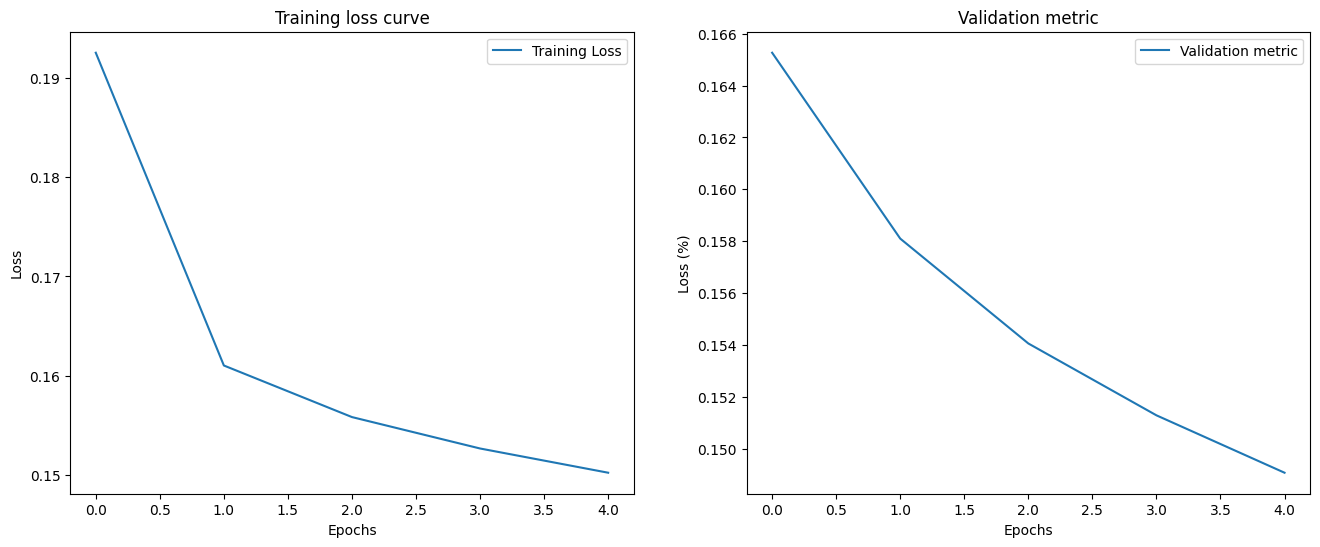

In [18]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation metric
plt.subplot(1, 2, 2)
plt.plot(valid_metric_list, label='Validation metric')
plt.title('Validation metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()


In [19]:
# Number of epochs to train the model
# MODIFICATION : Augmenter le nombre d'époques pour permettre une meilleure convergence.
# Number of epochs to train the model
n_epochs = 20

# Move the model to the device
model = model.to(device)

# Lists to store loss and accuracy for each epoch
train_loss_list = []
valid_metric_list = []

best_valid_metric = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    model.train()  # ensure the model is in training mode
    recon_metric = 0

    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        inputs = batch_data[0].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        recon_batch, _ = model(inputs)
        # calculate the loss
        loss = loss_function(recon_batch, inputs)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        recon_metric += loss.item() * inputs.size(0)

    # Calculate average training loss and accuracy over the epoch
    train_loss_list.append(recon_metric / len(train_loader.dataset))

    ###################
    # Validation step #
    ###################
    model.eval()  # set model to evaluation mode
    valid_metric = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            inputs = batch_data[0].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            recon, _ = model(inputs)
            # calculate the loss
            valid_metric += loss_function(recon, inputs).item() * inputs.size(0)

    # Compute average validation loss and accuracy
    valid_metric_list.append(valid_metric / len(valid_loader.dataset))

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss_list[-1]:.6f} \tValidation metric: {valid_metric_list[-1]:.6f}')

    # Save the model if it has the best validation loss
    if valid_metric_list[-1] < best_valid_metric:
        best_valid_metric = valid_metric_list[-1]
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number


# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation metric: {best_valid_metric:.6f}")


Epoch: 1 	Training Loss: 0.148476 	Validation metric: 0.147855
Epoch: 2 	Training Loss: 0.147029 	Validation metric: 0.146568
Epoch: 3 	Training Loss: 0.146076 	Validation metric: 0.145969
Epoch: 4 	Training Loss: 0.145194 	Validation metric: 0.145518
Epoch: 5 	Training Loss: 0.144575 	Validation metric: 0.144847
Epoch: 6 	Training Loss: 0.143982 	Validation metric: 0.144530
Epoch: 7 	Training Loss: 0.143544 	Validation metric: 0.144201
Epoch: 8 	Training Loss: 0.143169 	Validation metric: 0.143384
Epoch: 9 	Training Loss: 0.142770 	Validation metric: 0.143424
Epoch: 10 	Training Loss: 0.142374 	Validation metric: 0.143736
Epoch: 11 	Training Loss: 0.142050 	Validation metric: 0.143189
Epoch: 12 	Training Loss: 0.141781 	Validation metric: 0.142493
Epoch: 13 	Training Loss: 0.141516 	Validation metric: 0.142512
Epoch: 14 	Training Loss: 0.141195 	Validation metric: 0.142234
Epoch: 15 	Training Loss: 0.140986 	Validation metric: 0.142105
Epoch: 16 	Training Loss: 0.140777 	Validation me

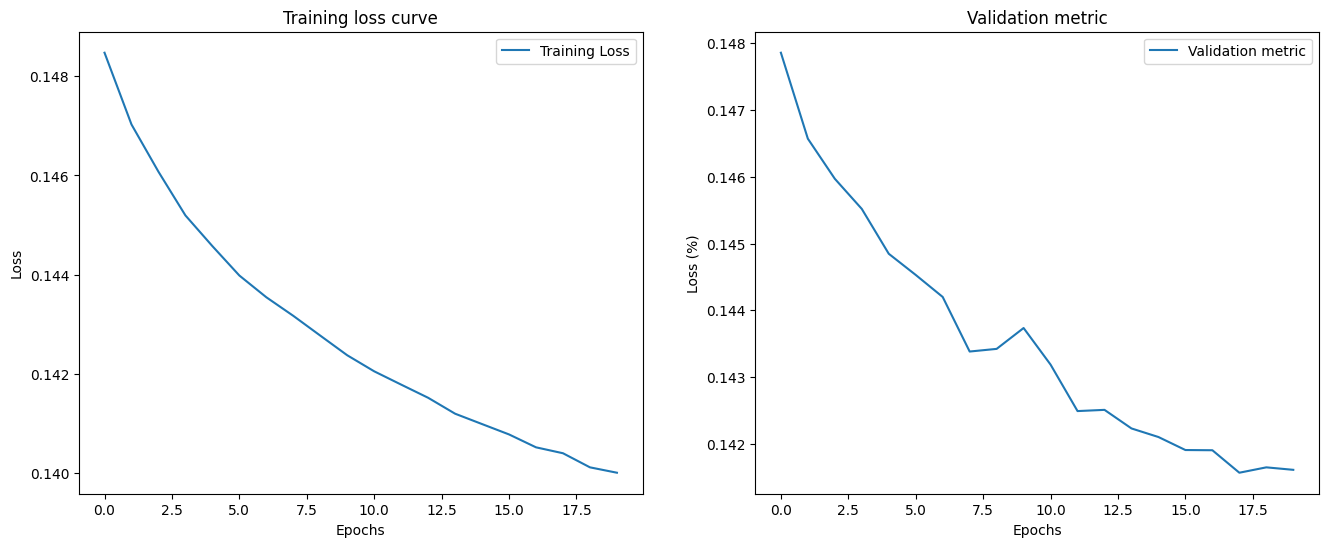

In [20]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation metric
plt.subplot(1, 2, 2)
plt.plot(valid_metric_list, label='Validation metric')
plt.title('Validation metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()


In [21]:
# initialize lists to monitor test loss and accuracy
test_metric = 0.0
model.eval() # prep model for *evaluation*

with torch.no_grad():  # disable gradient calculation during validation
    for batch_data in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        inputs = batch_data[0].to(device)
        recon, _ = model(inputs)
        # calculate the loss
        loss = loss_function(recon.float(), inputs.float())
        test_metric += loss.item() * inputs.size(0)

# calculate and print avg test loss
test_metric = test_metric / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_metric))

# Prepare next cell
dataiter = iter(test_loader)

Test Loss: 0.141340



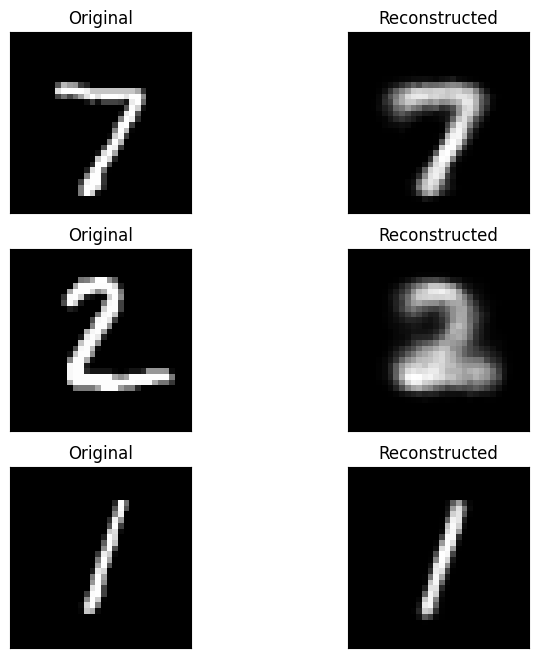

In [22]:
# obtain one batch of test images
batch_data = next(dataiter)

# get sample outputs
inputs = batch_data[0].to(device)
recons, _ = model(inputs)
# reconstruction images for display
recons = recons.detach().cpu().numpy()
inputs = inputs.detach().cpu().numpy()

# Plot the image, label and prediction
fig = plt.figure(figsize=(8, 8))
for idx in range(3):
    ax = fig.add_subplot(3, 2, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]), cmap='gray')
    ax.set_title('Original')
    ax = fig.add_subplot(3, 2, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(np.squeeze(recons[idx]), cmap='gray')
    ax.set_title('Reconstructed')


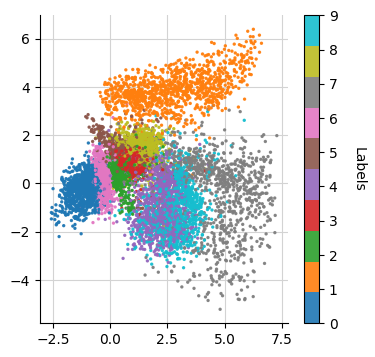

In [24]:
def get_test_embeddings(test_loader, encoder):
    # switch the model to evaluation mode
    encoder.eval()
    # initialize empty lists to store the embeddings and labels
    points = []
    label_idcs = []
    # iterate through the test loader
    for i, data in enumerate(test_loader):
        # move the images and labels to the appropriate device
        img, label = [d.to(device) for d in data]
        # encode the test images using the encoder
        z = encoder(img)
        # convert the embeddings and labels to NumPy arrays
        # and append them to the respective lists
        points.extend(z.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        # free up memory by deleting the images and labels
        del img, label
    # convert the embeddings and labels to NumPy arrays
    points = np.array(points)
    label_idcs = np.array(label_idcs)
    # return the embeddings and labels to the calling function
    return points, label_idcs


def plot_latent_space(test_loader, encoder, show=False):
    # get the embeddings and labels for the test images
    points, label_idcs = get_test_embeddings(test_loader, encoder)
    # create a new figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 8) if not show else (4, 4))
    # create a scatter plot of the embeddings, colored by the labels
    scatter = ax.scatter(
        x=points[:, 0],
        y=points[:, 1],
        s=2.0,
        c=label_idcs,
        cmap="tab10",
        alpha=0.9,
        zorder=2,
    )
    # remove the top and right spines from the plot
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # add a colorbar to the plot
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
    # if show is True, display the plot
    if show:
        # add a grid to the plot
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        # plt.show()
    # otherwise, save the plot to a file and close the figure
    else:
        plt.savefig("latent_space.png", bbox_inches="tight")
        plt.close()

plot_latent_space(test_loader, encoder, show=True)


/tmp/ipython-input-1370339093.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", num_classes)


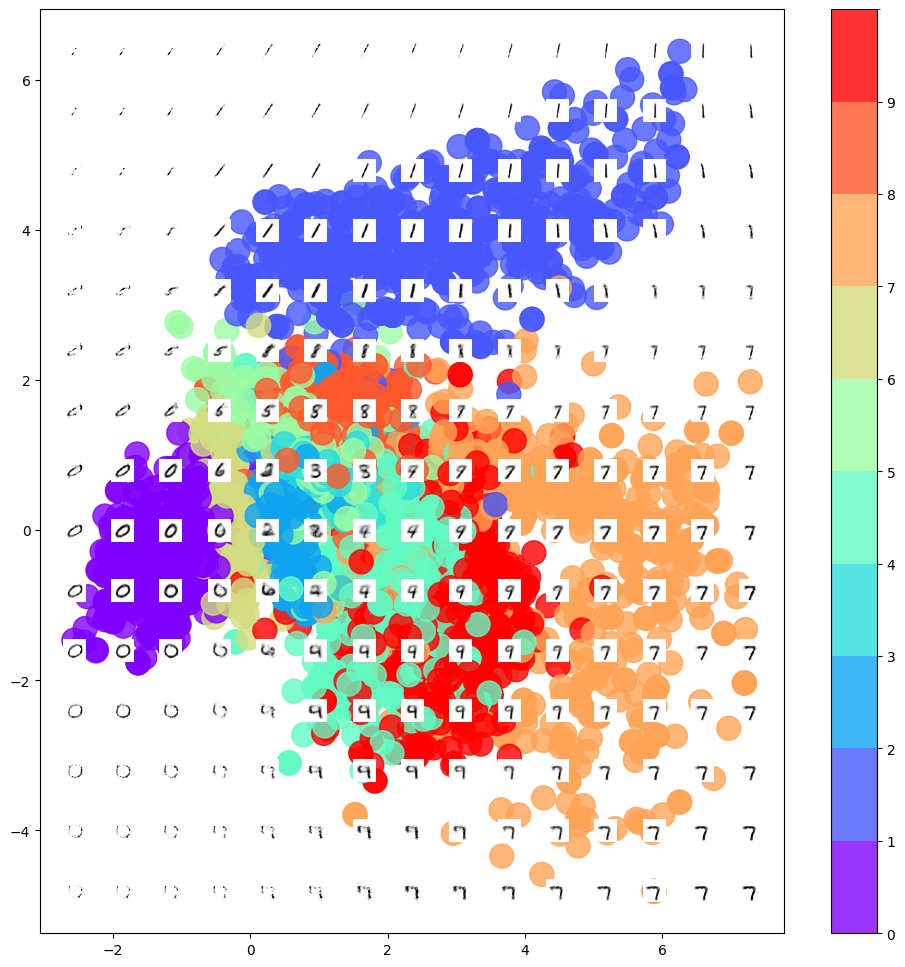

In [25]:
def get_random_test_images_embeddings(test_loader, encoder, imgs_visualize=5000):
    # get all the images and labels from the test loader
    all_images, all_labels = [], []
    for batch in test_loader:
        images_batch, labels_batch = batch
        all_images.append(images_batch)
        all_labels.append(labels_batch)
    # concatenate all the images and labels into a single tensor
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    # randomly select a subset of the images and labels to visualize
    index = np.random.choice(range(len(all_images)), imgs_visualize)
    images = all_images[index]
    labels = all_labels[index]
    # get the embeddings for all the test images
    points, _ = get_test_embeddings(test_loader, encoder)
    # select the embeddings corresponding to the randomly selected images
    embeddings = points[index]
    # return the randomly selected images, their labels, and their embeddings
    return images, labels, embeddings

def plot_image_grid_on_embeddings(
    test_loader, encoder, decoder, grid_size=15, figsize=12, show=True
):
    # get a random subset of test images
    # and their corresponding embeddings and labels
    _, labels, embeddings = get_random_test_images_embeddings(test_loader, encoder)
    # create a single figure for the plot
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    # define a custom color map with discrete colors for each unique label
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    cmap = cm.get_cmap("rainbow", num_classes)
    bounds = np.linspace(0, num_classes, num_classes + 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    # Plot the scatter plot of the embeddings colored by label
    scatter = ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        cmap=cmap,
        c=labels,
        norm=norm,
        alpha=0.8,
        s=300,
    )
    # Create the colorbar with discrete ticks corresponding to unique labels
    cb = plt.colorbar(scatter, ticks=range(num_classes), spacing="proportional", ax=ax)
    cb.set_ticklabels(unique_labels)
    # Create the grid of images to overlay on the scatter plot
    x = np.linspace(embeddings[:, 0].min(), embeddings[:, 0].max(), grid_size)
    y = np.linspace(embeddings[:, 1].max(), embeddings[:, 1].min(), grid_size)
    xv, yv = np.meshgrid(x, y)
    grid = np.column_stack((xv.ravel(), yv.ravel()))
    # convert the numpy array to a PyTorch tensor
    # and get reconstructions from the decoder
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    reconstructions = decoder(grid_tensor.to(device))
    # overlay the images on the scatter plot
    for i, (grid_point, img) in enumerate(zip(grid, reconstructions)):
        img = img.squeeze().detach().cpu().numpy()
        imagebox = OffsetImage(img, cmap="Greys", zoom=0.5)
        ab = AnnotationBbox(
            imagebox, grid_point, frameon=False, pad=0.0, box_alignment=(0.5, 0.5)
        )
        ax.add_artist(ab)

    plt.show()

plot_image_grid_on_embeddings(test_loader, encoder, decoder, show=True)

In [26]:
def get_random_latent_points(range_min=-2, range_max=2, latent_size=2):
    # Générer deux points aléatoires avec des coordonnées comprises entre `range_min` et `range_max`
    point1 = torch.FloatTensor(latent_size).uniform_(range_min, range_max)
    point2 = torch.FloatTensor(latent_size).uniform_(range_min, range_max)
    return point1, point2

def interpolate_images(decoder, point1, point2, steps=10):
    # Interpolate between point1 and point2 in the latent space
    alphas = np.linspace(0, 1, steps)
    interpolated_points = [point1 * (1 - alpha) + point2 * alpha for alpha in alphas]
    interpolated_points = torch.stack(interpolated_points).to(device)

    # Pass the interpolated points through the decoder to get reconstructed images
    interpolated_images = decoder(interpolated_points)

    # Return images as a list after detaching and converting to numpy
    return [img.squeeze().detach().cpu().numpy() for img in interpolated_images]

def save_animation_as_gif(images, filename="animation.gif", interval=200):
    fig, ax = plt.subplots(figsize = (4,4))
    img_display = ax.imshow(images[0], cmap="gray", vmin=0, vmax=1)
    ax.axis("off")

    def update(frame):
        img_display.set_data(images[frame])
        return [img_display]

    ani = FuncAnimation(fig, update, frames=len(images), interval=interval, blit=True)
    ani.save(filename, writer="pillow", fps=1000//interval)
    plt.close(fig)


First sampled point in latent space: tensor([-2., -2.])
Last sampled point in latent space: tensor([2., 2.])


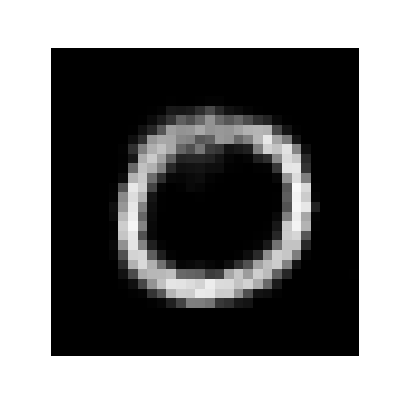

In [27]:
# Randomly select two points in the latent space
random_generation = False

if random_generation:
    # Example to generate deux random points
    point1, point2 = get_random_latent_points(latent_size=latent_size)
else:
    np_array_1 = np.array([-2,-2])
    point1 = torch.tensor(np_array_1, dtype=torch.float32)
    np_array_2 = np.array([2,2])
    point2 = torch.tensor(np_array_2, dtype=torch.float32)

print("First sampled point in latent space:", point1)
print("Last sampled point in latent space:", point2)

# Interpolate between the two points and decode to generate images
images = interpolate_images(decoder, point1, point2, steps=60)

# Animate the interpolated images
filename = "mnist_interpolation.gif"
save_animation_as_gif(images, filename=filename, interval=200)

# Affiche le GIF dans Jupyter
display(Image(filename=filename))